<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [38]:
data = pd.read_csv('/datasets/Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалим из таблицы строки, с пропусками в столбце `Tenure`, так как заполнить эти пропуски мы не можем, а они влияют на обучение модели.

In [40]:
data.dropna(subset=['Tenure'], inplace=True)

В предоставленных данных есть столбцы, которые не влияют на результат (`RowNumber`, `CustomerId`, `Surname`)

In [41]:
clear_data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
clear_data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Так же видим что в нашей таблице много категориальных данных, которые стоит преобразовать в числа с помощью OHE.

In [42]:
data_ohe = pd.get_dummies(clear_data, drop_first=True)
data_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разобьем данные на две выборки:

In [44]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_inter, features_test, target_inter, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_inter, target_inter, test_size=0.25, random_state=12345, stratify=target_inter)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(5454, 11) (5454,)
(1818, 11) (1818,)
(1819, 11) (1819,)


## Исследование задачи

Проверим сбалансированность:

0    7237
1    1854
Name: Exited, dtype: int64


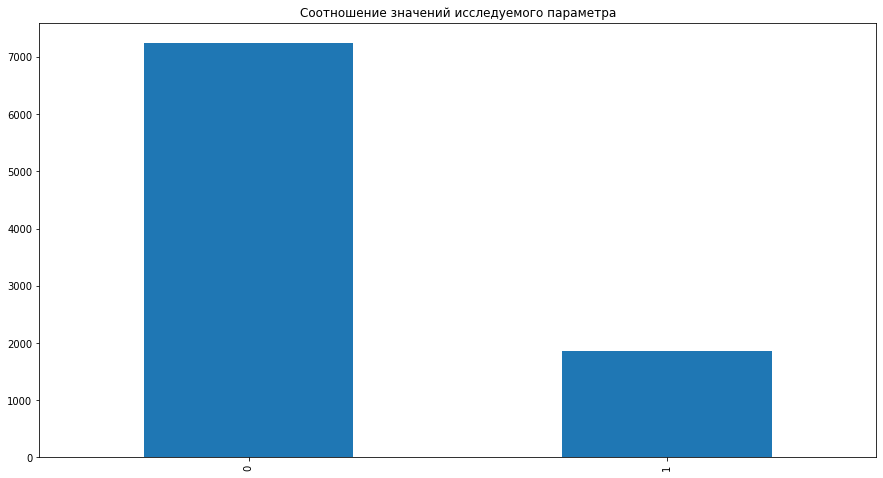

In [45]:
data_ohe['Exited'].value_counts().plot(kind='bar', figsize=(15, 8), title='Соотношение значений исследуемого параметра')
print(data_ohe['Exited'].value_counts())
plt.show()

Видим, что выборка несбалансированна, данные распределены примерно 72 : 18.

Изучим зависимость оттока клиентов от возраста

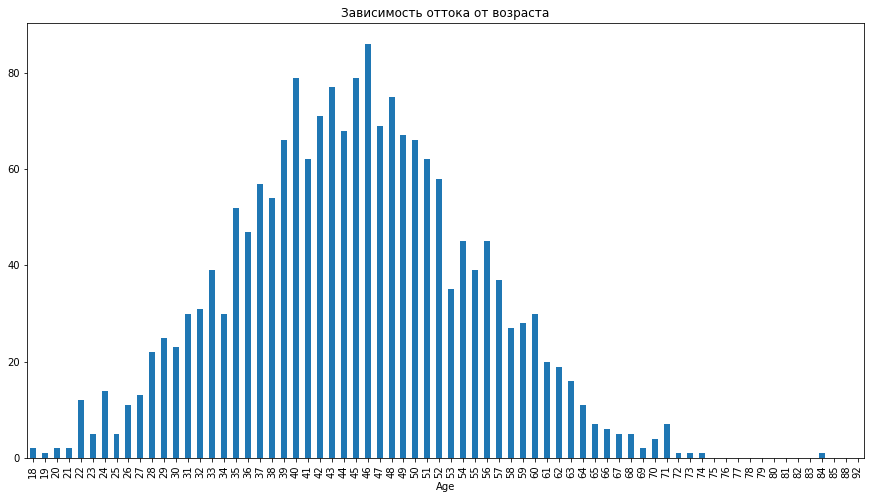

In [46]:
data_ohe.groupby('Age')['Exited'].sum().plot(figsize=(15, 8), kind='bar', title='Зависимость оттока от возраста')
plt.show()

Видим, что распределение близко к нормальному.

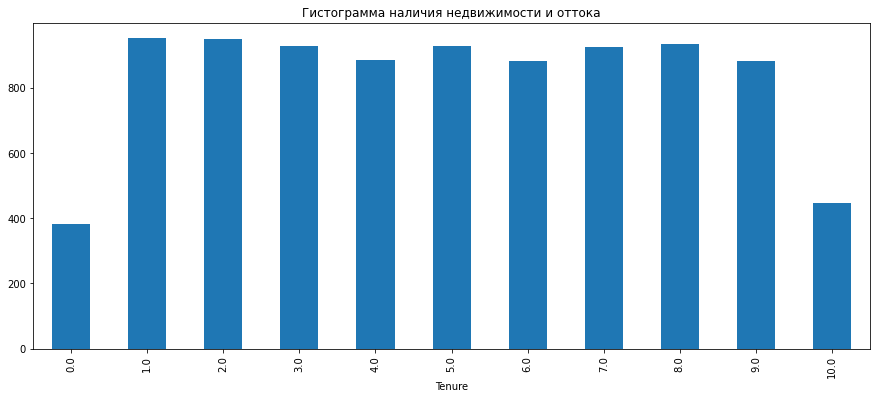

In [47]:
data_ohe.groupby('Tenure')['Exited'].count().plot(figsize=(15,6), kind='bar', title='Гистограмма наличия недвижимости и оттока')
plt.show()

По графику видно, что сильной зависимости не наблюдается.

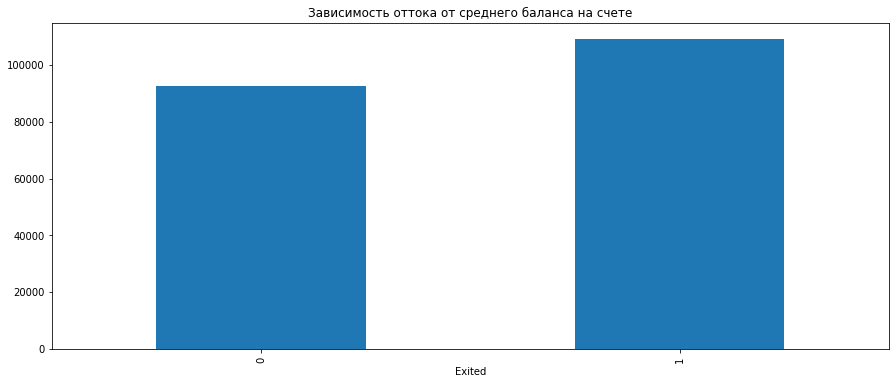

In [48]:
data_ohe.groupby('Exited')['Balance'].median().plot(figsize=(15,6), kind='bar', title='Зависимость оттока от среднего баланса на счете')
plt.show()

Видим, что сильной разницы в зависимости от баланса нет.

Стандартизируем выборку:

In [49]:
pd.options.mode.chained_assignment = None
numeric=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

Проверим, как будет выглядеть модель без балансировки

**Рассмотрим решающее дерево:**

In [52]:
best_model_tree = None
best_depth = 0
best_result = 0
for depth in range(1, 20, 1):
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    tree_model.fit(features_train, target_train)
    prediction = tree_model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        best_model_tree = tree_model
        best_result = result
        best_depth = depth

print('best_depth:',best_depth,'; F1:', best_result)

best_depth: 7 ; F1: 0.5605306799336649


**Рассмотрим случайный лес:**

In [53]:
best_forest = None
best_depth = 0
best_result = 0
best_est = 0
for depth in range(3, 16, 1):
    for est in range(20, 120, 5):
        forest = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        forest.fit(features_train, target_train)
        prediction = forest.predict(features_valid)
        result = f1_score(target_valid, prediction)
        if result > best_result:
            best_forest = forest
            best_result = result
            best_est = est
            best_depth = depth
            
print('best_depth:', best_depth, '; best_est:', best_est, '; F1:', best_result)

best_depth: 11 ; best_est: 20 ; F1: 0.5878378378378378


**Рассмотрим модель регрессии**

In [58]:
regression = LogisticRegression(random_state=12345)
regression.fit(features_train, target_train)
pred = regression.predict(features_valid)
print('F1:', f1_score(target_valid, pred))

F1: 0.0


Видно, что за из-за несбалансированности выборки падает значение F1_score

**Вывод: Лучшей моделью из исследованных является случайный лес с гиперпараметрами `max_depth = 11` и `n_estimators = 20` cо значением `F1 = 0.5878378378378378`. Для дальнейшего исследования необходимо сбалансировать выборку.**

## Борьба с дисбалансом

Рассмотрим два варианта балансировки.

**Воспользуемся техникой upsampling:**

In [59]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [60]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


**Воспользуемся техникой downsampling:**

In [61]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [62]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

**Сравним лучшую модель на трех выборках:**

In [63]:
%%time
forest_norm = RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345)
forest_norm.fit(features_train, target_train)
pred_norm = forest_norm.predict(features_valid)
print('F1:', f1_score(target_valid, pred_norm))

F1: 0.5878378378378378
CPU times: user 133 ms, sys: 16 µs, total: 133 ms
Wall time: 131 ms


In [64]:
%%time
forest_up = RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345)
forest_up.fit(features_upsampled, target_upsampled)
pred_up = forest_up.predict(features_valid)
print('F1:', f1_score(target_valid, pred_up))

F1: 0.5804020100502513
CPU times: user 163 ms, sys: 7.89 ms, total: 171 ms
Wall time: 169 ms


In [65]:
%%time
forest_down = RandomForestClassifier(max_depth=12, n_estimators=45, random_state=12345)
forest_down.fit(features_downsampled, target_downsampled)
pred_down = forest_down.predict(features_valid)
print('F1:', f1_score(target_valid, pred_down))

F1: 0.5915492957746479
CPU times: user 183 ms, sys: 3.98 ms, total: 187 ms
Wall time: 185 ms


**Вывод: Учитывая полученные результаты и небольшое различие между положительной и отрицательной выборками, выберем технику downsampling, так как результаты для данного метода получились лучше.**

## Тестирование модели

**Теперь сравним три модели на downsampling выборке:**

In [66]:
model_tree = DecisionTreeClassifier(max_depth=7, random_state=12345).fit(features_downsampled, target_downsampled)
pred_tree = model_tree.predict(features_test)
result = f1_score(target_test, pred_tree)

proba_tree = model_tree.predict_proba(features_test)
proba_one_test_tree = proba_tree[:, 1]
fpr_tree, tpr_tree, thresholds = roc_curve(target_test, proba_one_test_tree)
print('F1:', result)

F1: 0.5833333333333334


In [67]:
auc_roc_tree = roc_auc_score(target_test, proba_one_test_tree)
print('AUC-ROC:', auc_roc_tree)

AUC-ROC: 0.8232183809623089


In [70]:
pred_forest = forest_down.predict(features_test)
result = f1_score(target_test, pred_forest)

proba_forest = forest_down.predict_proba(features_test)
proba_one_test_forest = proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_test, proba_one_test_forest)
print('F1:', result)

F1: 0.6384039900249376


In [71]:
auc_roc_forest = roc_auc_score(target_test, proba_one_test_forest)
print('AUC-ROC:', auc_roc_forest)

AUC-ROC: 0.8536879569924498


In [74]:
model_reg = LogisticRegression(random_state=12345)
model_reg.fit(features_downsampled, target_downsampled)
pred_reg = model_reg.predict(features_test)
result = f1_score(target_test, pred_reg)

proba_reg = model_reg.predict_proba(features_test)
proba_one_test_reg = proba_reg[:, 1]
fpr_reg, tpr_reg, thresholds = roc_curve(target_test, proba_one_test_reg)
print('F1:', result)

F1: 0.0


In [75]:
auc_roc_reg = roc_auc_score(target_test, proba_one_test_reg)
print('AUC-ROC:', auc_roc_reg)

AUC-ROC: 0.4823178359220265


<Figure size 432x288 with 0 Axes>

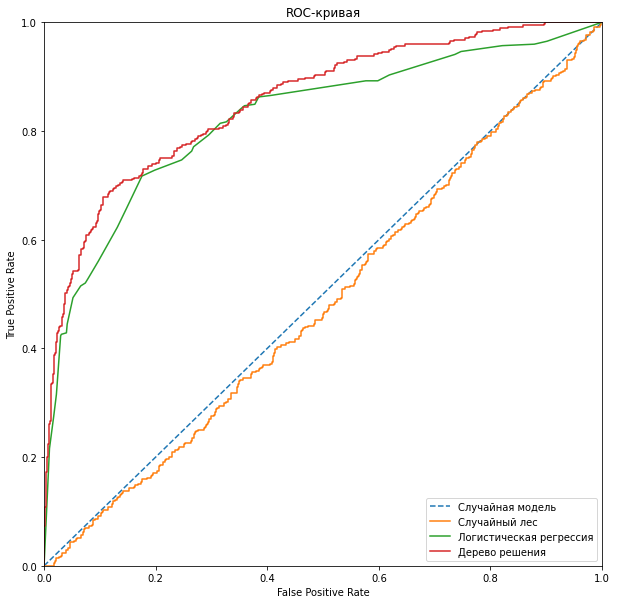

In [76]:
plt.figure()

plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_reg, tpr_reg)
plt.plot(fpr_tree, tpr_tree)
plt.plot(fpr_forest, tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель', 'Случайный лес', 'Логистическая регрессия', 'Дерево решения'), loc='lower right') 
plt.show()

In [77]:
result={'случайный лес': np.array([0.8536879569924498, 0.6384039900249376]),
        'решающее дерево': np.array([0.8232183809623089, 0.5833333333333334]),
        'логистическая регрессия': np.array([0.4823178359220265, 0.3561253561253562])}
result_df=pd.DataFrame(result, index=['AUC-ROC', 'F1'])
result_df

,случайный лес,решающее дерево,логистическая регрессия
AUC-ROC,0.853688,0.823218,0.482318
F1,0.638404,0.583333,0.356125


**Вывод:**
- 1) В результате исследования получено, что лучше всего перед обучением модели провести балансировку параметров с помощью техники `downsampling`.
- 2) Лучшее значение `F1` меры (`0.638404`) полученно для модели случайного леса с гиперпараметрами `max_depth = 11` и `n_estimators = 20`.
- 3) Лучшее знвчение метрики `AUC-ROC` (`0.853688`) так же получено для аналогичной модели случайного леса.
